### SETUP

In [375]:
# Import Dependencies

import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import time
from scipy.stats import linregress
import scipy.stats as stats


# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [614]:
# Functions

# Define a function to create Linear Regression plots

def linreg(x_values,y_values,x_label,y_label,title,x,y,):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(x,y),fontsize=15,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig(f"../Output/scatter_plots/{title}.jpg")
    plt.show()
    print(f"The r-squared is: {rvalue**2}")
    
def category(df,by):
    df['expected'] = sum(df['observed']) / len(df['observed'])
    plt.pie(df['observed'], labels=df[by], autopct='%1.1f%%')
    stats.chisquare(df['observed'], df['expected'])
    critical_value = stats.chi2.ppf(q = 0.95, df = (len(df.index)-1))
    st = stats.chisquare(df['observed'], df['expected']).statistic
    plt.title(f"Crime Rate Per {by}")
    if st > critical_value:
        plt.xlabel('Results are Statistically Significant per Chi^2 Criteria')
    else:
        plt.xlabel('Results are not Statistically Significant per Chi^2 Criteria')
    plt.savefig(f"../Output/pie_plots/Crime_Rate_Per_{by}.jpg")
    plt.show()
    
def category_test(df,by):
    df['expected'] = sum(df['observed']) / len(df['observed'])
    stats.chisquare(df['observed'], df['expected'])
    critical_value = stats.chi2.ppf(q = 0.95, df = (len(df.index)-1))
    st = stats.chisquare(df['observed'], df['expected']).statistic
    if st > critical_value:
        print('Results are Statistically Significant per Chi^2 Criteria')
    else:
        print('Results are not Statistically Significant per Chi^2 Criteria')

# 1. DATA IMPORT

In [573]:
# Import csv into DataFrame

tdot_df_raw = pd.read_csv("../Resources/Major_Crime_Indicators.csv")

population_data = pd.read_csv("../Resources/population_data.csv")

population_data['Population'] = population_data['Population'].str.replace(',', '').astype(int)

# 2. TRANSFORMATION

In [574]:
# Clean Data

# Remove unneccessary columns

tdot_df = tdot_df_raw[['premises_type','occurrenceyear', 'occurrencemonth','occurrencedayofweek','occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'ObjectId']]

# Drop Data pre-2015 and post-2021 due to inconsistencies and incomplete years

tdot_df = tdot_df[(tdot_df['occurrenceyear'] >= 2015) & (tdot_df['occurrenceyear'] <= 2021)]

print(f"The total number of rows dropped is: {len(tdot_df_raw.index)-len(tdot_df.index)}")
print(f"The percentage of rows dropped is: {'{:.2f}%'.format((len(tdot_df_raw.index)-len(tdot_df.index))*100/len(tdot_df_raw.index))}")

tdot_df.head()

The total number of rows dropped is: 52547
The percentage of rows dropped is: 17.44%


,premises_type,occurrenceyear,occurrencemonth,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,ObjectId
32000,House,2015.0,January,Thursday,10,Assault,137,Woburn,32001
32001,Outside,2015.0,January,Thursday,6,Auto Theft,79,University,32002
32003,House,2015.0,January,Monday,11,Break and Enter,34,Bathurst Manor,32004
32006,Outside,2015.0,January,Thursday,2,Auto Theft,132,Malvern,32007
32008,Apartment,2015.0,January,Monday,8,Break and Enter,120,Clairlea-Birchmount,32009


In [575]:
# merge the population data extracted previously 

population_data['Hood_ID'] = population_data['Hood_ID'].astype(str)

tdot_pop_df = tdot_df.merge(population_data, on='Hood_ID', how='left')

tdot_pop_df.head()

,premises_type,occurrenceyear,occurrencemonth,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,ObjectId,Population,lon,lat,District,d_lon,d_lat
0,House,2015.0,January,Thursday,10,Assault,137,Woburn,32001,53485.0,-79.231728,43.776470,Scarborough,-79.231752,43.776426
1,Outside,2015.0,January,Thursday,6,Auto Theft,79,University,32002,7607.0,-79.401800,43.662250,Old Toronto,-79.380323,43.648680
2,House,2015.0,January,Monday,11,Break and Enter,34,Bathurst Manor,32004,15873.0,-79.456886,43.762823,North York,-79.411079,43.761538
3,Outside,2015.0,January,Thursday,2,Auto Theft,132,Malvern,32007,43794.0,-79.221690,43.809160,Scarborough,-79.231752,43.776426
4,Apartment,2015.0,January,Monday,8,Break and Enter,120,Clairlea-Birchmount,32009,26984.0,-79.282797,43.716190,Scarborough,-79.231752,43.776426


In [576]:
# Convert NSA values to NaN in preparatation to drop them

tdot_df_drp = tdot_pop_df.replace("NSA",np.nan)

# Remove rows with incomplete data

tdot_df_drp = tdot_df_drp.dropna().reset_index(drop=True)

tdot_df_drp['occurrenceyear'] = tdot_df_drp['occurrenceyear'].astype(int)

tdot_df_drp['Population'] = tdot_df_drp['Population'].astype(int)

print(f"The total number of rows dropped is: {len(tdot_df.index)-len(tdot_df_drp.index)}")
print(f"The percentage of rows dropped is: {'{:.2f}%'.format((len(tdot_df.index)-len(tdot_df_drp.index))*100/len(tdot_df.index))}")

tdot_df_drp.head() # This is the primary DataFrame that will be used for further transofrmations

The total number of rows dropped is: 4037
The percentage of rows dropped is: 1.62%


,premises_type,occurrenceyear,occurrencemonth,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,ObjectId,Population,lon,lat,District,d_lon,d_lat
0,House,2015,January,Thursday,10,Assault,137,Woburn,32001,53485,-79.231728,43.776470,Scarborough,-79.231752,43.776426
1,Outside,2015,January,Thursday,6,Auto Theft,79,University,32002,7607,-79.401800,43.662250,Old Toronto,-79.380323,43.648680
2,House,2015,January,Monday,11,Break and Enter,34,Bathurst Manor,32004,15873,-79.456886,43.762823,North York,-79.411079,43.761538
3,Outside,2015,January,Thursday,2,Auto Theft,132,Malvern,32007,43794,-79.221690,43.809160,Scarborough,-79.231752,43.776426
4,Apartment,2015,January,Monday,8,Break and Enter,120,Clairlea-Birchmount,32009,26984,-79.282797,43.716190,Scarborough,-79.231752,43.776426


In [577]:
# Neighbourhood Mean Data

Hood_mean = tdot_df_drp.groupby(by=['Neighbourhood']).mean().reset_index(drop=False)

Hood_mean.head() # DataFrame with mean Neighbourhood Data

,Neighbourhood,occurrenceyear,occurrencehour,ObjectId,Population,lon,lat,d_lon,d_lat
0,Agincourt North,2017.904068,13.088258,152245.861857,29113.0,-79.262029,43.803660,-79.231752,43.776426
1,Agincourt South-Malvern West,2018.111227,11.785863,160288.772349,23757.0,-79.266438,43.783507,-79.231752,43.776426
2,Alderwood,2017.998487,12.632375,156122.190620,12054.0,-79.544905,43.600797,-79.513198,43.620495
3,Annex,2018.191226,11.655226,162934.101935,30526.0,-79.407585,43.669833,-79.380323,43.648680
4,Banbury-Don Mills,2017.872924,13.293141,151855.861372,27695.0,-79.343506,43.737257,-79.411079,43.761538


In [578]:
# Districts Grouped Data

# Toronto's Historic Districts are "North York, Scarborough, Etobicoke, East York, Old Toronto, York"

# Drop Neighbourhoods with invalid distrtics returned from Google API

tdot_df_districts = tdot_df_drp[(tdot_df_drp["District"] == "North York") |
                               (tdot_df_drp["District"] == "Scarborough") |
                               (tdot_df_drp["District"] == "Etobicoke") |
                               (tdot_df_drp["District"] == "East York") |
                               (tdot_df_drp["District"] == "Old Toronto") |
                               (tdot_df_drp["District"] == "York")
                                ]

print(f"The total number of rows dropped is: {len(tdot_df_drp.index)-len(tdot_df_districts.index)}")
print(f"The percentage of rows dropped is: {'{:.2f}%'.format((len(tdot_df_drp.index)-len(tdot_df_districts.index))*100/len(tdot_df_drp.index))}")


tdot_df_districts.head() # DataFrame with Invalid district rows dropped

The total number of rows dropped is: 35732
The percentage of rows dropped is: 14.61%


,premises_type,occurrenceyear,occurrencemonth,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,ObjectId,Population,lon,lat,District,d_lon,d_lat
0,House,2015,January,Thursday,10,Assault,137,Woburn,32001,53485,-79.231728,43.776470,Scarborough,-79.231752,43.776426
1,Outside,2015,January,Thursday,6,Auto Theft,79,University,32002,7607,-79.401800,43.662250,Old Toronto,-79.380323,43.648680
2,House,2015,January,Monday,11,Break and Enter,34,Bathurst Manor,32004,15873,-79.456886,43.762823,North York,-79.411079,43.761538
3,Outside,2015,January,Thursday,2,Auto Theft,132,Malvern,32007,43794,-79.221690,43.809160,Scarborough,-79.231752,43.776426
4,Apartment,2015,January,Monday,8,Break and Enter,120,Clairlea-Birchmount,32009,26984,-79.282797,43.716190,Scarborough,-79.231752,43.776426


In [264]:
# Group the data by district for Visual representation of crimes by district

district_population = tdot_df_districts.groupby(by=['d_lon', 'd_lat','District','Neighbourhood','Population']).count().reset_index()

district_crime_df = district_population.groupby(by=['d_lon', 'd_lat','District']).sum()[['Population', 'ObjectId']].reset_index()

district_crime_df

district_crime_df = district_crime_df.rename(columns = {'ObjectId' : 'Total_Crimes'})

district_crime_df['Crime_Per_1000'] = district_crime_df['Total_Crimes'] / district_crime_df['Population'] * 1000

district_crime_df # DataFrame with crimes grouped by district

,d_lon,d_lat,District,Population,Total_Crimes,Crime_Per_1000
0,-79.513198,43.620495,Etobicoke,287322,24758,86.168132
1,-79.450354,43.695679,York,131253,10820,82.436211
2,-79.411079,43.761538,North York,613178,47181,76.945031
3,-79.380323,43.648680,Old Toronto,706431,72455,102.564865
4,-79.341664,43.691201,East York,84063,5545,65.962433
5,-79.231752,43.776426,Scarborough,609807,48158,78.972527


In [581]:
# Neighbourhood Aggregate Data

hoods_agg = tdot_df_drp.groupby(by=['Hood_ID','Neighbourhood','Population','lon', 'lat']).count().reset_index()

hoods_agg = hoods_agg.rename(columns = {'ObjectId' : 'Total_Crimes'})

hoods_agg = hoods_agg[['Hood_ID','Neighbourhood','Population','lon', 'lat','Total_Crimes']]

hoods_agg['Crime_Per_1000'] = hoods_agg['Total_Crimes'] / hoods_agg['Population'] * 1000

hoods_agg = hoods_agg.sort_values(by='Crime_Per_1000', ascending=False).reset_index(drop=True)

hoods_agg.head() # DataFrame with aggregated crimes counts per neighbourhood and crime rate per 1000

,Hood_ID,Neighbourhood,Population,lon,lat,Total_Crimes,Crime_Per_1000
0,73,Moss Park,20506,-79.369105,43.653380,6199,302.301765
1,76,Bay Street Corridor,25797,-79.384224,43.656960,7278,282.125829
2,75,Church-Yonge Corridor,31340,-79.387639,43.673796,8455,269.783025
3,78,Kensington-Chinatown,17945,-79.397964,43.652984,4829,269.100028
4,79,University,7607,-79.401800,43.662250,1641,215.722361


In [549]:
# Top 5 and Bottom 5 crime/population Hoods

top_hoods = hoods_agg.head(5)

bottom_hoods = hoods_agg.tail(5)

top_hood_names = top_hoods['Neighbourhood'].tolist()

bottom_hood_names = bottom_hoods['Neighbourhood'].tolist()

focus_hood_names = [*top_hood_names, *bottom_hood_names]

focus_hood_names

focus_hoods = pd.DataFrame(columns=hoods_agg.columns)

for hood in focus_hood_names:
    focus_hood = hoods_agg[hoods_agg['Neighbourhood'] == hood]
    focus_hoods = pd.concat([focus_hoods,focus_hood]).reset_index(drop=True)
    
focus_hoods

focus_hoods['Crime_Per_1000'] = focus_hoods['Crime_Per_1000'].astype(float)

focus_hoods # DataFrame with top 5 and least 5 safe Neighbourhoods

,Hood_ID,Neighbourhood,Population,lon,lat,Total_Crimes,Crime_Per_1000
0,73,Moss Park,20506,-79.369105,43.65338,6199,302.301765
1,76,Bay Street Corridor,25797,-79.384224,43.65696,7278,282.125829
2,75,Church-Yonge Corridor,31340,-79.387639,43.673796,8455,269.783025
3,78,Kensington-Chinatown,17945,-79.397964,43.652984,4829,269.100028
4,79,University,7607,-79.4018,43.66225,1641,215.722361
5,46,Pleasant View,15818,-79.333416,43.784525,687,43.431534
6,133,Centennial Scarborough,13362,-79.148327,43.781684,557,41.685376
7,99,Mount Pleasant East,16775,-79.38475,43.705077,691,41.192250
8,97,Yonge-St.Clair,12528,-79.397993,43.687211,483,38.553640
9,116,Steeles,24623,-79.323501,43.811683,895,36.348130


In [586]:
# Neighbourhood Yearly Crime Rate Data preparation for focus neighbourhood plots

hoods_year = tdot_df_drp.groupby(by=['Neighbourhood','Population','occurrenceyear']).count()[['ObjectId']].reset_index()

hoods_year = hoods_year.rename(columns = {'ObjectId' : 'Total_Crimes'})

hoods_year['Crime_Per_1000'] = hoods_year['Total_Crimes'] / hoods_year['Population'] * 1000

hoods_year = hoods_year[['Neighbourhood', 'occurrenceyear', 'Crime_Per_1000']]

hoods_year.head()

hoods_year_list = [] # List to hold dataframes of focus neighbourhoods

for hood in focus_hood_names: # For loop to population the list of dataframes of focus neighbourhoods
    focus_hood = hoods_year[hoods_year['Neighbourhood'] == hood].reset_index(drop=True)
    hoods_year_list.append(focus_hood)


In [571]:
# Aggregate historic (yearly) Data for Toronto

toronto_population = tdot_df_drp.groupby(by=['Neighbourhood','Population']).count().reset_index()['Population'].sum()

toronto_year = tdot_df_drp.groupby(by=['occurrenceyear']).count()[['ObjectId']].reset_index()

toronto_year = toronto_year.rename(columns = {'ObjectId' : 'Total_Crimes'})

toronto_year['Crime_Per_1000'] = toronto_year['Total_Crimes'] / toronto_population * 1000

toronto_year # DataFrame with yearly aggregate data for all Neighbourhood coprising the city of Toronto

,occurrenceyear,Total_Crimes,Crime_Per_1000
0,2015,32568,11.922809
1,2016,33056,12.101461
2,2017,34810,12.743582
3,2018,36895,13.506879
4,2019,39109,14.317402
5,2020,34465,12.617281
6,2021,33746,12.354063


In [598]:
# Group data by premise type

premise_df = tdot_df_drp.groupby(by='premises_type').count()[['ObjectId']].reset_index()

premise_df = premise_df.rename(columns={ 'ObjectId' : 'observed'})

premise_df # DataFrame with Crimes Grouped by Premise Type

,premises_type,observed
0,Apartment,58770
1,Commercial,50251
2,Educational,6234
3,House,43433
4,Other,14500
5,Outside,64458
6,Transit,7003


In [597]:
# Group data by day type

day_df = tdot_df_drp.groupby(by='occurrencedayofweek').count()[['ObjectId']].reset_index()

day_df = day_df.rename(columns={ 'ObjectId' : 'observed', 'occurrencedayofweek' : 'day'})

day_df['weekday'] = 'none'

weekdays = ['Friday    ','Monday    ','Thursday  ','Tuesday   ','Wednesday ']

weekends = ['Saturday  ','Sunday    ']

for index, row in day_df.iterrows():
    if row['day'] in weekdays:
        day_df.loc[index,'weekday'] = 'Weekday'
    else:
        day_df.loc[index,'weekday'] = 'Weekend'

day_type_df = day_df.groupby(by='weekday').mean().reset_index()

day_type_df # DataFrame with Crimes Grouped by Day Type

,weekday,observed
0,Weekday,34683.0
1,Weekend,35617.0


In [594]:
# Group data by Season

occurrence_count = tdot_df_drp.groupby(by='occurrencemonth').count()['ObjectId']

occurrence_count

occurrence_sum = sum(tdot_df_drp.groupby(by='occurrencemonth').count()['ObjectId'])

occurrence_sum

month_df = occurrence_count.to_frame()

month_df[1] = occurrence_sum/len(occurrence_count.index)

month_df.columns = ["observed","expected"]

month_df['season'] = ""

seasons = {
'Spring': ['March', 'April', 'May'],
'Winter': ['December', 'January', 'February'],
'Summer': ['June', 'July', 'August'],
'Fall': ['September', 'October', 'November']
}

for season in seasons:
    for month in seasons[season]:
        month_df.loc[month, 'season'] = season

season_df = month_df.groupby(by='season').sum()

season_df = pd.DataFrame(season_df)

season_df = season_df.reset_index()

season_df # DataFrame with Crimes Grouped by Season

,season,observed,expected
0,Fall,63886,61162.25
1,Spring,58765,61162.25
2,Summer,64623,61162.25
3,Winter,57375,61162.25


In [595]:
# Groupby assault type

assault_df = tdot_df_drp.groupby(by='mci_category').count()[['ObjectId']].reset_index()

assault_df = assault_df.rename(columns={ 'ObjectId' : 'observed'})

assault_df # DataFrame with Crimes Grouped by Assault Type

,mci_category,observed
0,Assault,132115
1,Auto Theft,32417
2,Break and Enter,48812
3,Robbery,23263
4,Theft Over,8042


In [596]:
# Group Data by Time of Day

hour_df = tdot_df_drp.groupby(by='occurrencehour').count()[['ObjectId']].reset_index()

hour_df = hour_df.rename(columns={ 'ObjectId' : 'observed'})

bins = [0, 5.9, 11.9, 16.9, 24]

# Create the names for the five bins
group_names = ["Night", "Morning", "Afternoon", "Evening"]

hour_df["Time_of_day"] = pd.cut(hour_df["occurrencehour"], bins, labels=group_names, include_lowest=True)

hour_df

time_df = hour_df.groupby(by='Time_of_day')[['observed']].sum().reset_index()

time_df # DataFrame with Crimes Grouped by Time of Day

,Time_of_day,observed
0,Night,55575
1,Morning,41460
2,Afternoon,56461
3,Evening,91153


# 3. PLOTS

## 3.1 MAP Plots

### 3.1.1 Neighbourhood Locations

In [567]:
# Map displaying Neighbourhood locations

map_plot_1 = Hood_mean.hvplot.points(
    x="lon",
    y="lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    scale = 1,
    color = "Neighbourhood",
    legend = False,        # LEGEND turned off as it does not provide benefit with large number of unique points.
    xlabel = 'Longitude',
    ylabel = 'Latitude',
    title = 'Neighbourhood Locations'
)


# Display the map
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (Neighbourhood)

### 3.1.2 Visual Representation of Crime Rate by District

In [569]:
map_plot_2 = district_crime_df.hvplot.points(
    x="d_lon",
    y="d_lat",
    geo = True,
    tiles = "OSM",
    size = "Crime_Per_1000",
    frame_width = 700,
    frame_height = 500,
    scale = 10,
    color = "District",
    legend = True,        
    xlabel = 'Longitude',
    ylabel = 'Latitude',
    title = 'Crime Rate by District'
)


# Display the map
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [d_lon,d_lat]   (District,Crime_Per_1000)

### 3.1.3 Visual Representation of Crime Per 1000 people for  most and least safe districts


In [572]:
# Visualize Top and Bottom Hoods

map_plot_3 = focus_hoods.hvplot.points(
    x="lon",
    y="lat",
    geo = True,
    tiles = "OSM",
    size = "Crime_Per_1000",
    frame_width = 700,
    frame_height = 500,
    scale = 2,
    color = "Neighbourhood",
    legend = True,        
    xlabel = 'Longitude',
    ylabel = 'Latitude',
    title = 'Crime Rate by Neighbourhood (Top and Bottom 5)'
)


# Display the map
map_plot_3

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (Neighbourhood,Crime_Per_1000)

## 3.2 SCATTER Plots

### 3.2.1 Outputting Plots and regression analysis for the city of Toronto Aggregate Crimes per 1000 People

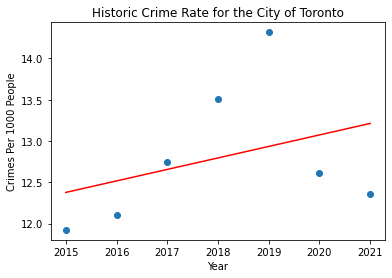

The r-squared is: 0.1264300099070376


In [617]:
# Creating a scatter and regression plot using the predefined function

x_val = toronto_year['occurrenceyear']
y_val = toronto_year['Crime_Per_1000']
x_label = 'Year'
y_label = 'Crimes Per 1000 People'
title = 'Historic Crime Rate for the City of Toronto'
x_loc = 14
y_loc = 2015

linreg(x_val,y_val,x_label,y_label,title,x_loc,y_loc)

### 3.2.2 Outputting Plots and regression analysis for the most and least safe 5 Nieghbourhoods in Toronto

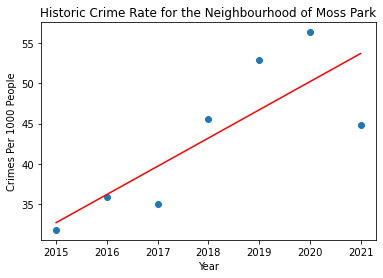

The r-squared is: 0.6510760019274734


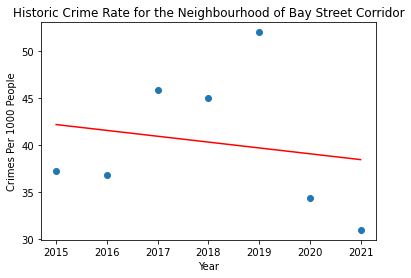

The r-squared is: 0.0325154950383764


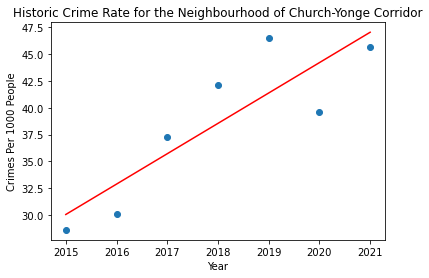

The r-squared is: 0.7506689850717332


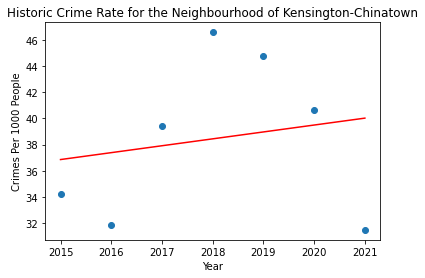

The r-squared is: 0.03504759185987554


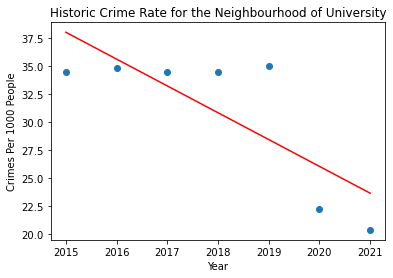

The r-squared is: 0.6251230552445661


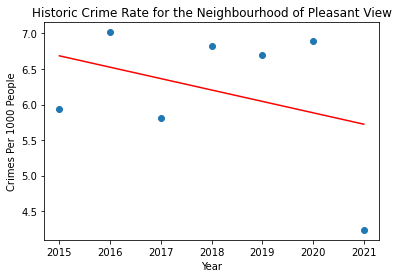

The r-squared is: 0.12273568367744447


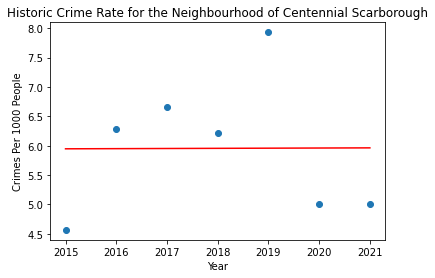

The r-squared is: 2.4135933577914423e-05


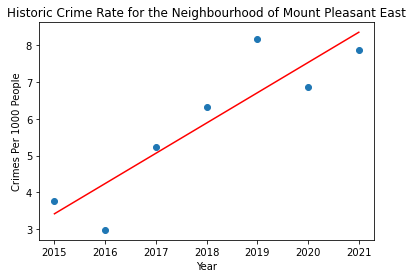

The r-squared is: 0.7995406542457283


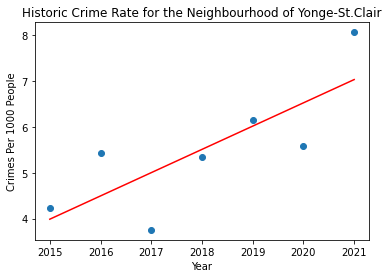

The r-squared is: 0.6169964168873656


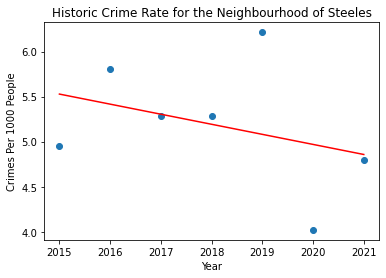

The r-squared is: 0.11540407972594205


In [616]:
# Creating a scatter and regression plot using the predefined function

for i, hood in enumerate(focus_hood_names): # for loop to create a plot for each of the focus neighbourhood dataframes
                                            # in their designated list
    x_val = hoods_year_list[i]['occurrenceyear']
    y_val = hoods_year_list[i]['Crime_Per_1000']
    x_label = 'Year'
    y_label = 'Crimes Per 1000 People'
    title = f"""Historic Crime Rate for the Neighbourhood of {hoods_year_list[i]['Neighbourhood'][0]}"""
    x_loc = 0
    y_loc = 0

    linreg(x_val,y_val,x_label,y_label,title,x_loc,y_loc)


## 3.3 Bar Plots Plots

### 3.3.1 Creating a bar plot to visually represent the relative crime rate per 1000 people for all Toronto Neighbourhoods


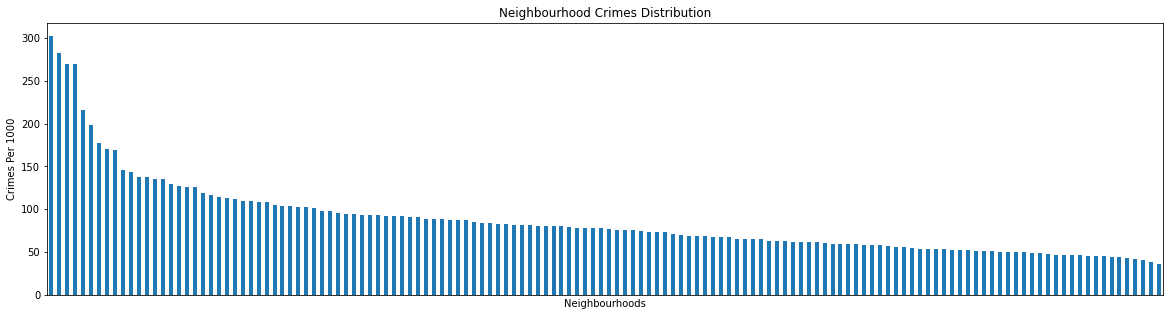

,Population,lon,lat,Total_Crimes,Crime_Per_1000
count,140.000000,140.000000,140.000000,140.000000,140.000000
mean,19511.221429,-79.399281,43.708838,1747.492857,86.928230
std,10033.589222,0.102265,0.051294,1496.270950,46.610983
min,6577.000000,-79.587410,43.593396,369.000000,36.348130
25%,12019.500000,-79.477396,43.671739,867.750000,57.988972
50%,16749.500000,-79.405102,43.700657,1307.000000,77.186654
75%,23854.500000,-79.327421,43.743927,2090.500000,97.552958
max,65913.000000,-79.148327,43.827367,9438.000000,302.301765


In [619]:
# Create a bar plot using pandas function and remove the x ticks since the plot is intended for visual comparison only

hoods_agg.plot(kind='bar',x='Hood_ID',y='Crime_Per_1000',xlabel="Neighbourhoods",ylabel='Crimes Per 1000',xticks=[],legend=False, title="Neighbourhood Crimes Distribution", figsize=(20,5))

plt.savefig(f"../Output/bar_plots/All_Neighbourhoods.jpg")


plt.show()

hoods_agg.describe()

### 3.3.2 Creating a bar plot to show the compare the most and least safe Neighbourhoods

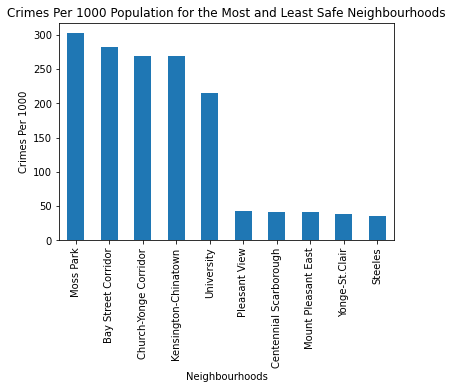

In [618]:
# Create a bar plot using pandas function 

focus_hoods.plot.bar(x='Neighbourhood',y='Crime_Per_1000',xlabel="Neighbourhoods",ylabel='Crimes Per 1000',legend=False, title="Crimes Per 1000 Population for the Most and Least Safe Neighbourhoods")

plt.savefig(f"../Output/bar_plots/Focus_Neighbourhoods.jpg")

plt.show()

## 3.4 Pie Plots

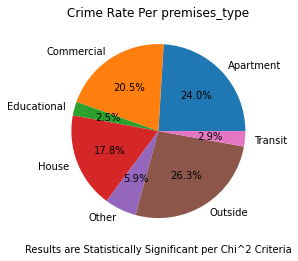

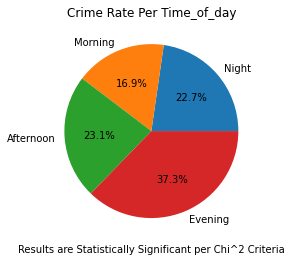

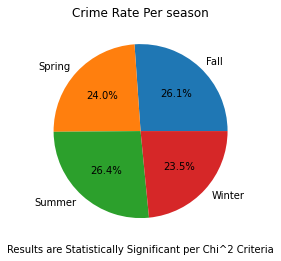

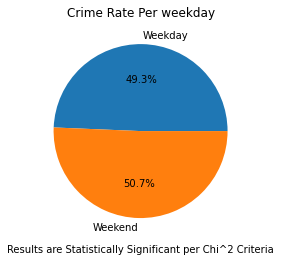

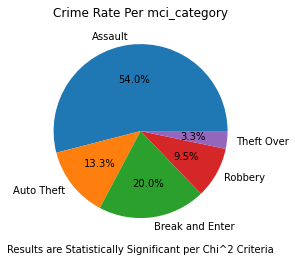

In [615]:
# Create pie plots for the required categorizations using the transformed DataFrames and defined function

category(premise_df,'premises_type')

category(time_df,'Time_of_day')

category(season_df,'season')

category(day_type_df,'weekday')

category(assault_df,'mci_category')
